In [1]:
# There is a versioning issue between seaborn and numpy that results in 
# a FutureWarning. This does not affect the results but creates an 
# annoying warning message we don't want to see every time.
# We can't do anything about it, the developers of seaborn need to update
# their code to the newest NumPy standards.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Mini-Project: Property Scraping

We will be scraping property listings in Kuala Lumpur from https://www.iproperty.com.my/sale/kuala-lumpur/all-residential/. Our goal is to analyze the property market in the city.

To ensure no issues with the scraping itself, files have been downloaded beforehand and put into the folder `iproperty`. Each HTML file corresponds to a page of property listings. Our (altered) scraping process will therefore be to analyze the HTML of the original website to find out how to extract the information we want and then apply that extraction to the HTML files stored on disk; these are direct copies of each listing page.

## Stage One: Extracting Information
The first step is to extract information from each HTML page. Look at the (real) iproperty page (https://www.iproperty.com.my/sale/kuala-lumpur/all-residential/) and figure out how to extract the following information from each individual property listing:

1. The neighborhood in Kuala Lumpur
2. The price of the property
3. The number of rooms, bathrooms, and car parks
4. The type of property, e.g. "Condominium (Corner)"
5. The square footage
6. The furnishing state
7. The URL to the property listing details

Once you've figured out how to extract this data from a single entry, write a script that loops over all entries and pages and saves the data in a pandas data frame. Be sure to use the locally saved pages in the `iproperty/` for this so that we can avoid long waiting times due to a bad network connection!

The data frame should have a structure like so:

| Neighborhood | Price | No. Rooms | No. Bathrooms | No. Car Parks | Property Type | Square Footage | Furnishing State | URL |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| KLCC | 1450000 | 2 | 2 | 1 | Condominium | 867 | Fully Furnished | http://www.link.com |

Not all entries will have this missing information. Be sure that your code takes this into account.

Save the dataframe to disk.

In [2]:
%matplotlib inline
import requests
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
url = "https://www.iproperty.com.my/sale/kuala-lumpur/all-residential/"
response = requests.get(url)

soup = BeautifulSoup(response.text, "html.parser")

In [4]:
# Attempt to extract info from one example
listing = soup.find("li", attrs={"class": "bWJbOM"})

def scrape_listing(listing):
    try:
        price = listing.find("li", attrs={"class": "listing-primary-price-item"}).get_text()
    except AttributeError:
        price = None
    
    try:
        # Locations don't always have a tag class!
        # Non-regex version
        for link in listing.find_all("a"):
            if "Kuala Lumpur" in link.get_text():
                location = link.get_text()
                break        
    except AttributeError:
        location = None
    
    try:
        prop_type = listing.find("p", attrs={"class": "property-type-content"})
        if prop_type is None:
            prop_type = listing.find("div", attrs={"class": "eqkyrG"}).get_text()
        else:
            prop_type = prop_type.get_text()
    except AttributeError:
        prop_type = None
    
    try:
        prop_size = listing.find("li", attrs={"class": ["builtUp-attr", "landArea-attr"]}).find("a").get_text()
    except AttributeError:
        prop_size = None
    
    try:
        prop_furnished = listing.find("li", attrs={"class": "furnishing-attr"}).find("a").get_text()
    except AttributeError:
        prop_furnished = None

    try:
        rooms = listing.find("li", attrs={"class": "bedroom-facility"}).get_text()
    except AttributeError:
        rooms = None
        
    try:
        bathrooms = listing.find("li", attrs={"class": "bathroom-facility"}).get_text()
    except AttributeError:
        bathrooms = None
        
    try:
        carParks = listing.find("li", attrs={"class": "carPark-facility"}).get_text()
    except AttributeError:
        carParks = None

    try:
        url = listing.find("a")["href"]
    except AttributeError:
        url = None

    entry = pd.Series(data={
        "Location": location,
        "Price": price, 
        "Rooms": rooms,
        "Bathrooms": bathrooms, 
        "Car Parks": carParks,
        "Property Type": prop_type,
        "Size": prop_size, 
        "Furnishing": prop_furnished,
        "URL": url})
    return entry

scrape_listing(listing)

Location                             KLCC, Kuala Lumpur
Price                                      RM 1,238,000
Rooms                                                 2
Bathrooms                                             2
Car Parks                                             1
Property Type                               Condominium
Size                             Built-up : 736 sq. ft.
Furnishing                             Partly Furnished
URL              /property/klcc/10-stonor/sale-6597351/
dtype: object

In [5]:
# Loop through all examples of a page
def scrape_page(page_id):
    with open("iproperty_kl/page_{}.html".format(page_id), "r") as f:
        html = f.read()
    
    soup = BeautifulSoup(html, "html.parser")
    
    listings = soup.find_all("li", attrs={"class": "bWJbOM"})
    page_listings = []
    for listing in listings:
        page_listings.append(scrape_listing(listing))
    return pd.DataFrame(page_listings)

scrape_page(1)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,URL
0,"KLCC, Kuala Lumpur","RM 1,250,000",2+1,3,2,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished,/property/klcc/setia-sky-residences/sale-6528715/
1,"Damansara Heights, Kuala Lumpur","RM 6,800,000",6,7,None,Bungalow,Land area : 6900 sq. ft.,Partly Furnished,/property/damansara-heights/sale-6692423/
2,"Dutamas, Kuala Lumpur","RM 1,030,000",3,4,2,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished,/property/dutamas/concerto-north-kiara/sale-68...
3,"Cheras, Kuala Lumpur",None,None,None,None,None,None,None,/new-property/property/cheras/j-dupion/new-5811/
4,"Bukit Jalil, Kuala Lumpur","RM 900,000",4+1,3,2,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished,/property/bukit-jalil/the-rainz/sale-6636230/
5,"Ttdi, Burhanuddin Helmi, Kl, Kuala Lumpur, Tam...","RM 5,350,000",4+2,5,4,Bungalow,Land area : 7200 sq. ft.,Partly Furnished,/property/taman-tun-dr-ismail/sale-6474574/
6,"Seputeh, Kuala Lumpur",None,None,None,None,None,None,None,/new-property/property/seputeh/setia-sky-seput...
7,"Taman Tun Dr Ismail, Kuala Lumpur","RM 2,600,000",5,4,4,Semi-detached House,Land area : 3600 sq. ft.,Partly Furnished,/property/taman-tun-dr-ismail/sale-6455023/
8,"Taman Tun Dr Ismail, Kuala Lumpur","RM 1,950,000",4+1,4,3,2-sty Terrace/Link House (EndLot),Land area : 25x75 sq. ft.,Partly Furnished,/property/taman-tun-dr-ismail/sale-5375170/
9,"Sri Petaling, Kuala Lumpur","RM 385,000",3,2,1,Apartment (Intermediate),Built-up : 904 sq. ft.,Partly Furnished,/property/sri-petaling/1-petaling/sale-5788891/


In [6]:
# Loop through all pages
# This takes a while, so only do this if the output file doesn't exist yet
if not os.path.exists("Properties_raw.csv"):
    all_listings = []
    for page_counter in range(1, 2704):
        print("Page {}".format(page_counter))
        all_listings.append(scrape_page(page_counter))

    properties = pd.concat(all_listings)
    properties = properties.reset_index(drop=True)
    properties.to_csv("Properties_raw.csv", index=False)

## Stage Two: Data Pre-Processing
Next, we want to clean the data. 

1. An error in the formatting on iproperty will occasionally claim properties to have 31, 41, 51, etc. rooms. This is, obviously, nonsense. In reality, these properties have 3+1, 4+1, and 5+1 rooms. Change this in your data to reflect it accordingly, i.e. turn "N1" into "N+1". We're okay with the rooms being a categorical variable
2. The square footage may ocassionally be in varying formats, e.g. "900 sq. ft." or "20x35 sq. ft". Find a way to convert them, e.g. multiply them, so that all values in this column become valid numbers
3. We want only one kind of "not available" value. For example, "Furnishing State" may have missing values, i.e. empty strings, or take on the value "Unknown". Make sure that anything that doesn't describe a definitive furnishing state is changed to "Unknown". Do this for all other columns as well.
4. Look at unique values of each individual text column determine if there are any you could consolidate, i.e. combine if they are similar enough. Likewise, look for misspellings that need to be corrected.

In [7]:
properties = pd.read_csv("Properties_raw.csv")
properties.sample(5)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,URL
27712,"Jalan Klang Lama (Old Klang Road), Kuala Lumpur","RM 395,000",1,2.0,NaN,Serviced Residence (EndLot),Built-up : 775 sq. ft.,Fully Furnished,/property/jalan-klang-lama-old-klang-road/the-...
2962,"Kepong, Kuala Lumpur","RM 580,000",3,2.0,3.0,1-sty Terrace/Link House (Intermediate),Land area : 130. sq. ft.,Fully Furnished,/property/kepong/sale-6723519/
46469,"KLCC, Kuala Lumpur","RM 4,344,600",3+1,4.0,NaN,Condominium,"Built-up : 2,228 sq. ft.",Partly Furnished,/property/klcc/the-binjai-on-the-park/sale-409...
44617,"Kuchai Lama, Kuala Lumpur","RM 300,000",3,2.0,1.0,Apartment (Intermediate),Built-up : 820 sq. ft.,Unfurnished,/property/kuchai-lama/residensi-kuchaimas/sale...
14090,"Taman Melawati, Kuala Lumpur","RM 1,479,999",3+1,4.0,NaN,Townhouse,"Built-up : 3,674 sq. ft.",NaN,/property/taman-melawati/sale-5892770/


### Clean Location

In [8]:
# A common issue is capitalization, so let's make everything lower case
properties["Location"] = properties.Location.str.lower()

In [9]:
# Strip ", Kuala Lumpur" from the location
properties["Location"] = properties["Location"].apply(lambda x: x.replace(", kuala lumpur", ""))

In a number of cases, there are still multiple "locations" separated by commas. For these, use only the last item in the list, i.e. what is behind the last comma

In [10]:
properties.loc[properties.Location.str.contains(",")].sample(5)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,URL
47901,"taman seputeh, seputeh","RM 1,800,000",3+2,3.0,3.0,3.5-sty Terrace/Link House (Intermediate),Land area : 22x100 sq. ft.,Partly Furnished,/property/seputeh/sale-6282193/
34884,"bukit robson condominium, seputeh","RM 720,000",2,2.0,1.0,Condominium (Corner),"Built-up : 1,044 sq. ft.",Partly Furnished,/property/seputeh/bukit-robson-condominium/sal...
13464,"desa u-thant, ampang","RM 2,000,000",3+1,4.0,2.0,Apartment (Corner),"Built-up : 2,480 sq. ft.",Fully Furnished,/property/ampang/desa-u-thant/sale-6621220/
28388,"kuala lumpur, oug","RM 1,088,000",4+1,4.0,2.0,2-sty Terrace/Link House (Intermediate),Land area : 22x75 sq. ft.,Partly Furnished,/property/oug/sale-6586929/
35185,"kuala lumpur, bangsar","RM 30,698,400",NaN,NaN,NaN,Residential Land (Corner),Land area : 25582 sq. ft.,NaN,/property/bangsar/sale-3919653/


In [11]:
def strip_if_comma_separated(entry):
    if "," in entry:
        return entry.split(",")[-1].strip()
    else:
        return entry
    
properties["Location"] = properties["Location"].apply(strip_if_comma_separated)

Lets look at the unique location values

In [12]:
properties["Location"].value_counts()

mont kiara                                          5897
klcc                                                5230
cheras                                              4533
jalan klang lama (old klang road)                   2854
setapak                                             2710
bukit jalil                                         2593
kepong                                              2270
bangsar                                             1897
desa parkcity                                       1530
damansara heights                                   1411
dutamas                                             1247
ampang                                              1234
sentul                                              1149
sungai besi                                         1122
taman tun dr ismail                                 1088
sri hartamas                                        1063
taman desa                                          1025
wangsa maju                    

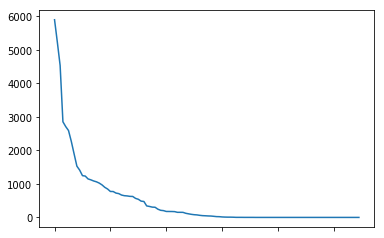

In [13]:
properties["Location"].value_counts().plot()

Combining and filtering these intelligently requires domain expertise, i.e. sound knowledge of neighborhoods in KL. As this will be a laborious, mostly manual task, we shall skip it and accept some problematic location values.

### Price

In [14]:
properties.sample(5)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,URL
38708,wangsa maju,"RM 235,000",2,1.0,1.0,Flat (Intermediate),Built-up : 640 sq. ft.,Unfurnished,/property/wangsa-maju/seksyen-2-wangsa-maju-fl...
20670,cheras,"RM 375,000",3,2.0,1.0,Townhouse (Intermediate),Land area : 1320 sq. ft.,Partly Furnished,/property/cheras/sale-6718725/
37096,jalan klang lama (old klang road),"RM 620,000",2,2.0,1.0,Serviced Residence,Built-up : 852 sq. ft.,Partly Furnished,/property/jalan-klang-lama-old-klang-road/citi...
51656,sentul,"RM 500,000",3,2.0,1.0,Serviced Residence,Land area : 948 sq. ft.,Unfurnished,/property/sentul/sentul-village/sale-6527805/
52981,damansara heights,"RM 4,312,100",6+1,6.0,NaN,Bungalow (Intermediate),"Built-up : 8,919 sq. ft.",NaN,/property/damansara-heights/sale-6643796/


In [15]:
# Strip the price of the "RM" as well as commas
def strip_price(text):
    try:
        text = text.replace("RM", "")
        text = text.replace(",", "")
        text = text.strip()
        return float(text)
    # If any of the above fails, just return None/NaN.
    # We want to ensure this is a numeric column
    except:
        return None

properties["Price"] = properties["Price"].apply(strip_price)

In [16]:
properties.sample(5)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,URL
20166,klcc,1198000.0,3,2.0,1.0,Serviced Residence (Intermediate),"Built-up : 1,259 sq. ft.",Fully Furnished,/property/klcc/my-habitat/sale-6576353/
11653,klcc,2062000.0,3,2.0,1.0,Condominium,"Built-up : 1,031 sq. ft.",Partly Furnished,/property/klcc/stonor-3/sale-5235396/
22574,klcc,800000.0,1,1.0,1.0,Serviced Residence (Intermediate),Built-up : 583 sq. ft.,Fully Furnished,/property/klcc/fraser-place-lot-163/sale-6632869/
1785,jalan klang lama (old klang road),700000.0,4,2.0,2.0,Condominium,"Built-up : 1,073 sq. ft.",Partly Furnished,/property/jalan-klang-lama-old-klang-road/peta...
24193,cheras,825000.0,4,2.0,NaN,1-sty Terrace/Link House (Corner),Land area : 256 sq. ft.,Partly Furnished,/property/cheras/sale-6841075/


### Number of Rooms
Some of the properties have "N+1" rooms. To make plotting easier later on, we want a numerical version of the `Rooms` column, `Rooms_num` so that e.g. "3+1" is converted to 4.

In [17]:
properties["Rooms"].unique()

array(['2+1', '6', '3', nan, '4+1', '4+2', '5', '4', '3+1', '6+1', '5+1',
       '3+2', '1', '2', '1+1', '5+2', '2+2', '7+1', 'Studio', '7', '6+',
       '14', '12', '8', '7+', '1+2', '8+', '8+1', '13+', '20 Above', '9',
       '10', '10+1', '15+', '9+1', '10+', '11', '18', '11+1', '13+1',
       '12+', '9+', '16', '13'], dtype=object)

In [18]:
def convert_room_num(rooms):
    try:
        if rooms.endswith("+"):
            return int(rooms[:-1])
        if re.search("[0-9]*\+[0-9]*", rooms) is not None:
            tmp = rooms.split("+")
            return int(tmp[0]) + int(tmp[1])
        if rooms == "20 Above":
            return 20
        if rooms == "Studio":
            return 1
        return int(rooms)
    except AttributeError:
        return rooms

# Any column in the format "N+M" should be added
properties["Rooms_num"] = properties["Rooms"].apply(convert_room_num)

In [19]:
properties[["Rooms", "Rooms_num"]].sample(15)

,Rooms,Rooms_num
44753,3+1,4.0
35543,4,4.0
52104,3,3.0
18492,5+1,6.0
41065,5,5.0
36748,3,3.0
38582,2,2.0
46282,3+1,4.0
52165,3,3.0
10262,3,3.0


### Property Type

In [20]:
properties["Property Type"].value_counts()

Condominium                                  11552
Serviced Residence                            7207
Condominium (Corner)                          5736
Condominium (Intermediate)                    5134
Serviced Residence (Intermediate)             3269
2-sty Terrace/Link House (Intermediate)       2440
Serviced Residence (Corner)                   2378
Bungalow                                      1746
2-sty Terrace/Link House                      1041
Bungalow (Intermediate)                        946
3-sty Terrace/Link House (Intermediate)        940
Semi-detached House (Intermediate)             909
Semi-detached House                            848
Bungalow (Corner)                              702
Apartment                                      691
Apartment (Intermediate)                       671
1-sty Terrace/Link House (Intermediate)        497
Residential Land                               485
2-sty Terrace/Link House (Corner)              474
2.5-sty Terrace/Link House (Int

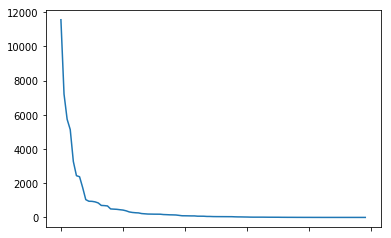

In [21]:
properties["Property Type"].value_counts().plot()

### Furnishing
We're very happy with the furnishing column!

In [22]:
properties["Furnishing"].value_counts()

Partly Furnished    26605
Fully Furnished     13987
Unfurnished          5753
Unknown               608
Name: Furnishing, dtype: int64

### Size
The size apparently always has the same structure:

```
[Built-up/Land area] : [Value] sq. ft.
```

In [23]:
properties[["Size"]].sample(25)

,Size
17365,Land area : 20x70 sq. ft.
28561,Built-up : 837 sq. ft.
37600,"Built-up : 2,098 sq. ft."
22974,Land area : 21x70 sq. ft.
35492,"Built-up : 3,897 sq. ft."
41968,"Built-up : 1,485 sq. ft."
2256,"Built-up : 2,718 sq. ft."
12503,Land area : 1400 sq. ft.
3357,"Built-up : 2,755 sq. ft."
38360,"Built-up : 1,328 sq. ft."


So let's create two new column that indicate whether this is built-up or land area and store the actual square footage.

In [24]:
def split_size(val, index=0):
    try:
        return val.split(":")[index].strip()
    except AttributeError:
        return val
    
properties["Size Type"] = properties["Size"].apply(split_size, index=0)
properties["Size_num"] = properties["Size"].apply(split_size, index=1)

Now lets strip the new `Size_num` column like we did the `Price` column.

In [25]:
def convert_size_num(size):
    try:
        size = size.replace(",", "")
        size = size.replace("sq. ft.", "")
        size = size.replace("sf", "")
        size = size.strip()
        size = size.lower()
        if "x" in size:
            size = size.split("x")
            return int(size[0].strip()) * int(size[1].strip())
        else:
            return int(size)
    # If any of the above doesn't work, just turn it into None/NaN
    # We want to guarantee this column is numeric
    except:
        return None
        
properties["Size_num"] = properties["Size_num"].apply(convert_size_num)

In [26]:
properties.sample(15)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,URL,Rooms_num,Size Type,Size_num
8100,klcc,690000.0,2,2.0,1.0,Condominium,Built-up : 919 sq. ft.,Fully Furnished,/property/klcc/vista-damai/sale-6360817/,2.0,Built-up,919.0
46927,kepong,300000.0,3,2.0,1.0,Apartment (Intermediate),Built-up : 850 sq. ft.,Fully Furnished,/property/kepong/hijau-ria-kepong-indah/sale-6...,3.0,Built-up,850.0
48685,sentul,1550000.0,3+1,3.0,2.0,Condominium,"Built-up : 1,750 sq. ft.",Fully Furnished,/property/sentul/the-maple-condominium/sale-64...,4.0,Built-up,1750.0
40798,mont kiara,670000.0,2,2.0,1.0,Condominium,Land area : 0 sq. ft.,Partly Furnished,/property/mont-kiara/laman-suria/sale-6789353/,2.0,Land area,0.0
50491,cheras,153000000.0,NaN,NaN,NaN,Residential Land,Land area : 25acre sq. ft.,NaN,/property/cheras/sale-6376469/,NaN,Land area,NaN
8769,klcc,8100000.0,3+2,4.0,NaN,Condominium (Intermediate),"Built-up : 3,218 sq. ft.",Partly Furnished,/property/klcc/the-binjai-on-the-park/sale-266...,5.0,Built-up,3218.0
18195,mont kiara,2250000.0,3+1,4.0,NaN,Condominium (Corner),"Built-up : 2,700 sq. ft.",Partly Furnished,/property/mont-kiara/28-mont-kiara-mk-28/sale-...,4.0,Built-up,2700.0
50931,cheras,470000.0,3,2.0,2.0,Condominium (Intermediate),"Built-up : 1,018 sq. ft.",Unfurnished,/property/cheras/the-holmes-1/sale-6384911/,3.0,Built-up,1018.0
13994,jalan ipoh,850000.0,4,3.0,NaN,2-sty Terrace/Link House (Intermediate),Land area : 22x80 sq. ft.,Partly Furnished,/property/jalan-ipoh/sale-6040149/,4.0,Land area,1760.0
41247,bukit jalil,1380000.0,5,5.0,2.0,2-sty Terrace/Link House (Intermediate),Land area : 22x72 sq. ft.,NaN,/property/bukit-jalil/sale-6420292/,5.0,Land area,1584.0


As a last step to this, we want to calculate the price per area.

In [27]:
properties["Price per Area"] = properties["Price"] / properties["Size_num"]

In [28]:
# Save our pre-processed file
properties.to_csv("Properties_preprocessed.csv")

## Stage Three: Analysis
We're done/sick of preprocessing and want to do some analysis now.

### ??? By Neighborhood
The most pressing question of course is how properties differ between neighborhoods. For this, we'll look at how price, area, and number of rooms differs. To make our plots less cluttered, we'll only use the most common neighborhoods in our data

In [29]:
properties.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,URL,Rooms_num,Size Type,Size_num,Price per Area
0,klcc,1250000.0,2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished,/property/klcc/setia-sky-residences/sale-6528715/,3.0,Built-up,1335.0,936.329588
1,damansara heights,6800000.0,6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished,/property/damansara-heights/sale-6692423/,6.0,Land area,6900.0,985.507246
2,dutamas,1030000.0,3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished,/property/dutamas/concerto-north-kiara/sale-68...,3.0,Built-up,1875.0,549.333333
3,cheras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/new-property/property/cheras/j-dupion/new-5811/,NaN,NaN,NaN,NaN
4,bukit jalil,900000.0,4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished,/property/bukit-jalil/the-rainz/sale-6636230/,5.0,Built-up,1513.0,594.844679


In [30]:
num_neighborhoods = 20
popular_neighborhoods = properties["Location"].value_counts().head(num_neighborhoods).index
properties_reduced = properties.loc[properties["Location"].isin(popular_neighborhoods)]

#### Price

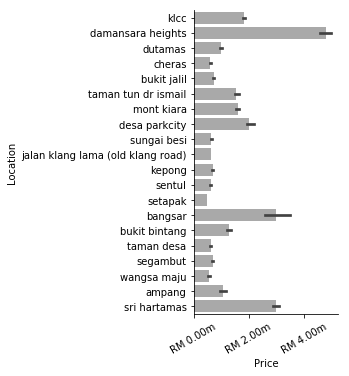

In [31]:
price_fig = sns.catplot(
    data=properties_reduced, x="Price", y="Location", kind="bar", 
    estimator=np.median, color="darkgrey")

price_fig.set_xticklabels(rotation=30)
price_fig.ax.xaxis.set_major_formatter(plt.FuncFormatter(
    lambda num, tick_num: "RM {:.2f}m".format(num/1000000)))

Only looking at the price would conceal important information about the size of the properties, so we'll look at the price per area.

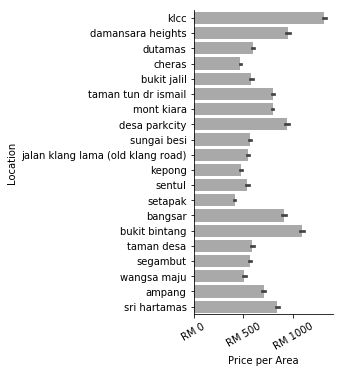

In [32]:
ppa_fig = sns.catplot(
    data=properties_reduced, x="Price per Area", y="Location", kind="bar", 
    estimator=np.median, color="darkgrey")

ppa_fig.set_xticklabels(rotation=30)
ppa_fig.ax.xaxis.set_major_formatter(plt.FuncFormatter(
    lambda num, tick_num: "RM {:.0f}".format(num)))

#### Area

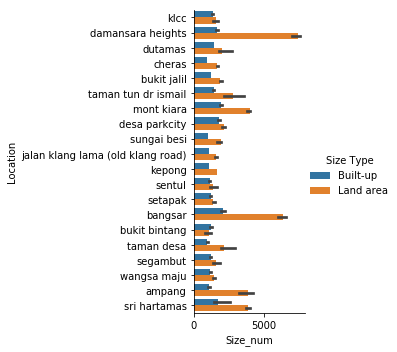

In [33]:
sns.catplot(
    data=properties_reduced, x="Size_num", y="Location", kind="bar", 
    estimator=np.median, hue="Size Type")

#### Room Number

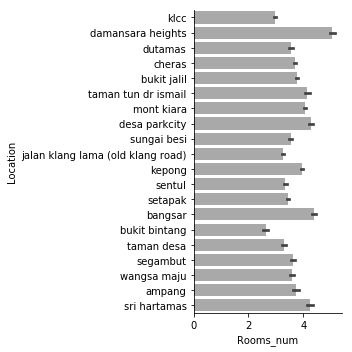

In [34]:
sns.catplot(
    data=properties_reduced, x="Rooms_num", y="Location", kind="bar", 
    estimator=np.mean, color="darkgrey")